# Image Clustering: With rotation

<div class="alert alert-warning">

**Warning:** Agglomerative clustering scales badly with dataset size. This leads to high memory usage (about 360 GB on Kale).

</div>

In [1]:
import warnings
from abc import ABC, abstractmethod

import matplotlib.pyplot as plt
import numpy as np
from hdbscan import HDBSCAN
from numba.errors import NumbaDeprecationWarning, NumbaWarning
from numpy.random import RandomState
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

from dpemu import runner
from dpemu.dataset_utils import load_mnist_unsplit
from dpemu.filters.image import Rotation
from dpemu.ml_utils import reduce_dimensions
from dpemu.nodes import Array
from dpemu.nodes.series import Series
from dpemu.plotting_utils import visualize_best_model_params, visualize_scores, visualize_classes, \
    print_results_by_model

warnings.simplefilter("ignore", category=NumbaDeprecationWarning)
warnings.simplefilter("ignore", category=NumbaWarning)

/wrk/users/thalvari/dpEmu/venv/lib/python3.7/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
/wrk/users/thalvari/dpEmu/venv/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
def get_data():
    return load_mnist_unsplit(70000)

In [3]:
def get_err_root_node():
    err_img_node = Array(reshape=(28, 28))
    err_root_node = Series(err_img_node)
    err_img_node.addfilter(Rotation("min_angle", "max_angle"))
    return err_root_node

In [4]:
def get_err_params_list():
    angle_steps = np.linspace(0, 84, num=8)
    err_params_list = [{"min_angle": -a, "max_angle": a} for a in angle_steps]
    return err_params_list

In [5]:
class Preprocessor:
    def __init__(self):
        self.random_state = RandomState(42)

    def run(self, _, data, params):
        reduced_data = reduce_dimensions(data, self.random_state)
        return None, reduced_data, {"reduced_data": reduced_data}

In [6]:
class AbstractModel(ABC):

    def __init__(self):
        self.random_state = RandomState(42)

    @abstractmethod
    def get_fitted_model(self, data, params):
        pass

    def run(self, _, data, params):
        labels = params["labels"]
        fitted_model = self.get_fitted_model(data, params)
        return {
            "AMI": round(adjusted_mutual_info_score(labels, fitted_model.labels_, average_method="arithmetic"), 3),
            "ARI": round(adjusted_rand_score(labels, fitted_model.labels_), 3),
        }


class KMeansModel(AbstractModel):

    def __init__(self):
        super().__init__()

    def get_fitted_model(self, data, params):
        labels = params["labels"]
        n_classes = len(np.unique(labels))
        return KMeans(n_clusters=n_classes, random_state=self.random_state).fit(data)


class AgglomerativeModel(AbstractModel):

    def __init__(self):
        super().__init__()

    def get_fitted_model(self, data, params):
        labels = params["labels"]
        n_classes = len(np.unique(labels))
        return AgglomerativeClustering(n_clusters=n_classes).fit(data)


class HDBSCANModel(AbstractModel):

    def __init__(self):
        super().__init__()

    def get_fitted_model(self, data, params):
        return HDBSCAN(
            min_samples=params["min_samples"],
            min_cluster_size=params["min_cluster_size"],
            core_dist_n_jobs=1
        ).fit(data)

In [7]:
def get_model_params_dict_list(data, labels):
    n_data = data.shape[0]
    divs = [12, 15, 20, 30, 45, 65, 90]
    min_cluster_size_steps = [round(n_data / div) for div in divs]
    min_samples_steps = [1, 5, 10]
    return [
        {"model": KMeansModel, "params_list": [{"labels": labels}]},
        {"model": AgglomerativeModel, "params_list": [{"labels": labels}]},
        {"model": HDBSCANModel, "params_list": [{
            "min_cluster_size": min_cluster_size,
            "min_samples": min_samples,
            "labels": labels
        } for min_cluster_size in min_cluster_size_steps for min_samples in min_samples_steps]},
    ]

In [8]:
def visualize(df, label_names, dataset_name, data):
    visualize_scores(
        df,
        score_names=["AMI", "ARI"],
        is_higher_score_better=[True, True],
        err_param_name="max_angle",
        title=f"{dataset_name} clustering scores with rotation",
    )
    visualize_best_model_params(
        df,
        model_name="HDBSCAN",
        model_params=["min_cluster_size", "min_samples"],
        score_names=["AMI", "ARI"],
        is_higher_score_better=[True, True],
        err_param_name="max_angle",
        title=f"Best parameters for {dataset_name} clustering"
    )
    visualize_classes(
        df,
        label_names,
        err_param_name="max_angle",
        reduced_data_column="reduced_data",
        labels_column="labels",
        cmap="tab10",
        title=f"{dataset_name} (n={data.shape[0]}) true classes with rotation"
    )
    plt.show()

In [9]:
def main():
    data, labels, label_names, dataset_name = get_data()

    df = runner.run(
        train_data=None,
        test_data=data,
        preproc=Preprocessor,
        preproc_params=None,
        err_root_node=get_err_root_node(),
        err_params_list=get_err_params_list(),
        model_params_dict_list=get_model_params_dict_list(data, labels),
    )

    print_results_by_model(df, ["min_angle", "reduced_data", "labels"])
    visualize(df, label_names, dataset_name, data)

100%|██████████| 8/8 [11:45<00:00, 88.18s/it] 


Agglomerative #1


,AMI,ARI,max_angle,time_err,time_pre,time_mod
0,0.888,0.819,0.0,5.404,445.732,185.305
1,0.871,0.804,12.0,5.886,465.016,183.202
2,0.805,0.707,24.0,6.258,448.705,184.230
3,0.701,0.542,36.0,5.708,454.822,186.735
4,0.689,0.530,48.0,6.299,461.554,185.352
5,0.607,0.419,60.0,16.806,448.424,185.581
6,0.580,0.398,72.0,6.675,452.017,188.154
7,0.522,0.342,84.0,16.912,447.885,186.312


HDBSCAN #1


,AMI,ARI,max_angle,min_cluster_size,min_samples,time_err,time_pre,time_mod
0,0.902,0.853,0.0,5833.0,1.0,5.404,445.732,2.263
1,0.901,0.852,0.0,5833.0,5.0,5.404,445.732,2.498
2,0.903,0.853,0.0,5833.0,10.0,5.404,445.732,2.572
3,0.902,0.853,0.0,4667.0,1.0,5.404,445.732,2.222
4,0.901,0.852,0.0,4667.0,5.0,5.404,445.732,2.456
5,0.903,0.853,0.0,4667.0,10.0,5.404,445.732,2.530
6,0.902,0.853,0.0,3500.0,1.0,5.404,445.732,2.171
7,0.901,0.852,0.0,3500.0,5.0,5.404,445.732,2.416
8,0.903,0.853,0.0,3500.0,10.0,5.404,445.732,2.516
9,0.902,0.853,0.0,2333.0,1.0,5.404,445.732,2.170


KMeans #1


,AMI,ARI,max_angle,time_err,time_pre,time_mod
0,0.886,0.817,0.0,5.404,445.732,1.163
1,0.863,0.794,12.0,5.886,465.016,1.379
2,0.801,0.702,24.0,6.258,448.705,1.382
3,0.765,0.654,36.0,5.708,454.822,1.749
4,0.656,0.492,48.0,6.299,461.554,2.179
5,0.640,0.474,60.0,16.806,448.424,2.301
6,0.567,0.386,72.0,6.675,452.017,2.628
7,0.536,0.356,84.0,16.912,447.885,2.123


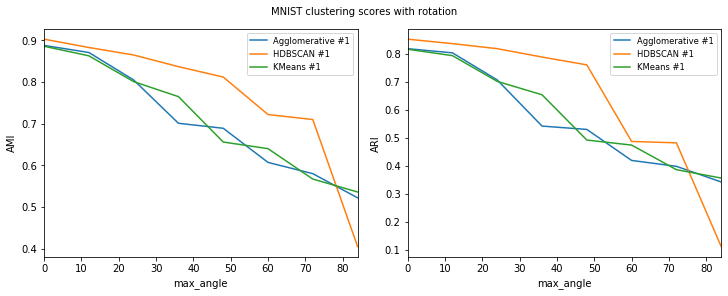

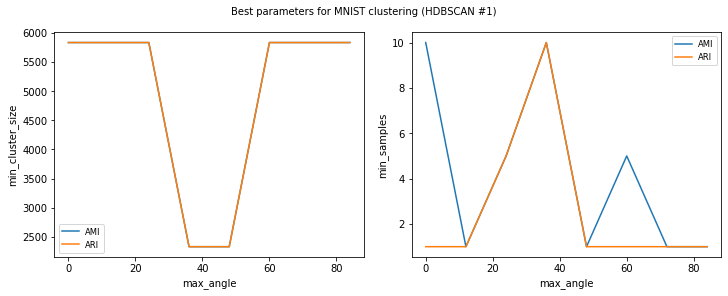

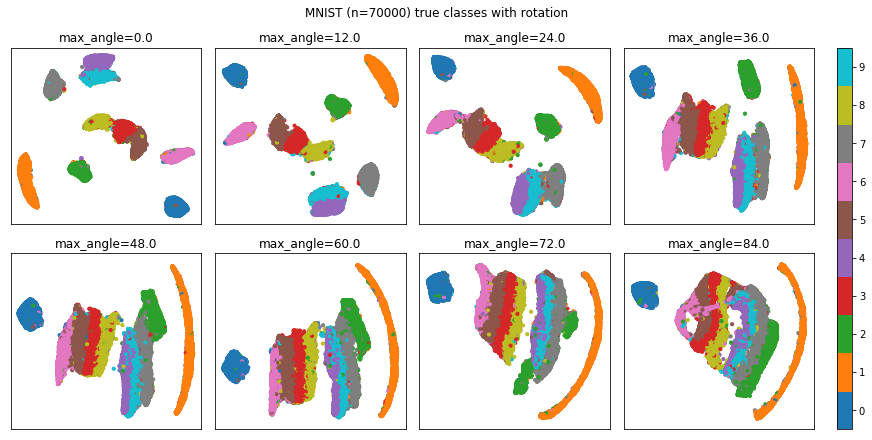

In [10]:
main()

The notebook for this case study can be found [here](https://github.com/dpEmu/dpEmu/blob/master/docs/case_studies/Image_Clustering_With_Rotation.ipynb).